In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1.5) 

import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm

import scipy

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import f1_score, accuracy_score

from IPython.display import clear_output, FileLink


import keras
from keras import backend as K

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras import layers


print(os.listdir('../input/'))
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

SIZE = 224
BATCH_SIZE = 64

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

['resnet50', '2019-3rd-ml-month-with-kakr']


/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

# Load Data, EDA

* Train data

In [0]:
train_df = pd.read_csv('../input/2019-3rd-ml-month-with-kakr/train.csv')
train_df.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [0]:
train_df.describe()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
count,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,64.450250,108.103103,637.145145,416.097097,99.058358
std,80.943666,106.854930,410.671550,274.215428,56.508850
min,1.000000,1.000000,72.000000,46.000000,1.000000
25%,19.000000,41.000000,390.000000,245.000000,51.000000
50%,39.000000,79.000000,570.000000,361.000000,99.000000
75%,78.000000,137.000000,745.000000,476.000000,148.000000
max,1648.000000,1646.000000,5205.000000,3389.000000,196.000000


In [0]:
class_count = train_df.groupby('class')['img_file'].count().values
class_count

array([55, 39, 53, 52, 50, 55, 48, 56, 51, 41, 47, 45, 51, 52, 53, 53, 48,
       53, 49, 57, 52, 53, 49, 56, 49, 42, 44, 51, 53, 51, 54, 51, 52, 55,
       51, 49, 48, 50, 45, 48, 44, 43, 55, 55, 40, 52, 43, 53, 46, 52, 53,
       51, 55, 49, 49, 57, 46, 54, 55, 45, 53, 46, 54, 37, 56, 51, 48, 49,
       46, 53, 38, 56, 55, 54, 54, 54, 50, 46, 60, 53, 56, 56, 48, 52, 54,
       53, 54, 49, 54, 51, 48, 49, 48, 54, 55, 51, 52, 57, 34, 42, 52, 48,
       49, 53, 54, 51, 55, 54, 55, 53, 52, 56, 53, 56, 56, 46, 53, 51, 83,
       53, 55, 49, 55, 47, 54, 52, 51, 48, 48, 51, 52, 54, 52, 42, 52, 30,
       54, 49, 53, 52, 42, 40, 49, 57, 54, 53, 54, 56, 53, 45, 54, 44, 55,
       53, 53, 48, 45, 36, 45, 54, 59, 56, 45, 54, 55, 51, 59, 52, 48, 54,
       57, 54, 54, 51, 38, 47, 54, 51, 55, 53, 47, 57, 52, 50, 48, 48, 54,
       54, 50, 53, 57, 53, 51, 56, 53, 49])

In [0]:
print(f"Min count class: {np.argmin(class_count)+1}, Max count class: {np.argmax(class_count)+1}")

Min count class: 136, Max count class: 119


In [0]:
print(f"Min: {np.min(class_count)}, Max {np.max(class_count)}, Mean {np.mean(class_count):.2f}, STD {np.std(class_count):.2f}, Total num {sum(class_count)}")

Min: 30, Max 83, Mean 50.97, STD 5.36, Total num 9990


* Class information

In [0]:
class_info = pd.read_csv('../input/2019-3rd-ml-month-with-kakr/class.csv')
class_info.set_index('id', inplace=True)
class_info.head()

,name
id,
1,AM General Hummer SUV 2000
2,Acura RL Sedan 2012
3,Acura TL Sedan 2012
4,Acura TL Type-S 2008
5,Acura TSX Sedan 2012


* Test data

In [0]:
test_df = pd.read_csv('../input/2019-3rd-ml-month-with-kakr/test.csv')
test_df.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93


# Image pre-processing

In [0]:
TRAIN_IMG_PATH = '../input/2019-3rd-ml-month-with-kakr/train'
TEST_IMG_PATH = '../input/2019-3rd-ml-month-with-kakr/test'

In [0]:
def crop_boxing_img(img_name, margin=16) :
    if img_name.split('_')[0] == "train" :
        PATH = TRAIN_IMG_PATH
        data = train_df
    elif img_name.split('_')[0] == "test" :
        PATH = TEST_IMG_PATH
        data = test_df
        
    img = Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)
    
    if abs(pos[2] - pos[0]) > width or abs(pos[3] - pos[1]) > height:
        print(f'{img_name} is wrong bounding box, img size: {img.size},  bbox_x1: {pos[0]}, bbox_x2: {pos[2]}, bbox_y1: {pos[1]}, bbox_y2: {pos[3]}')
        return img

    return img.crop((x1,y1,x2,y2))

In [0]:
train_path = '../train_crop'
test_path = '../test_crop'

In [0]:
if (os.path.isdir(train_path) == False):
    os.mkdir(train_path)

if (os.path.isdir(test_path) == False):
    os.mkdir(test_path)
    
for i, image in enumerate(tqdm(train_df['img_file'])):
    cropped = crop_boxing_img(image)
    cropped.save(os.path.join(train_path, image))
    
for i, image in enumerate(tqdm(test_df['img_file'])):
    cropped = crop_boxing_img(image)
    cropped.save(os.path.join(test_path, image))

* Display sample images

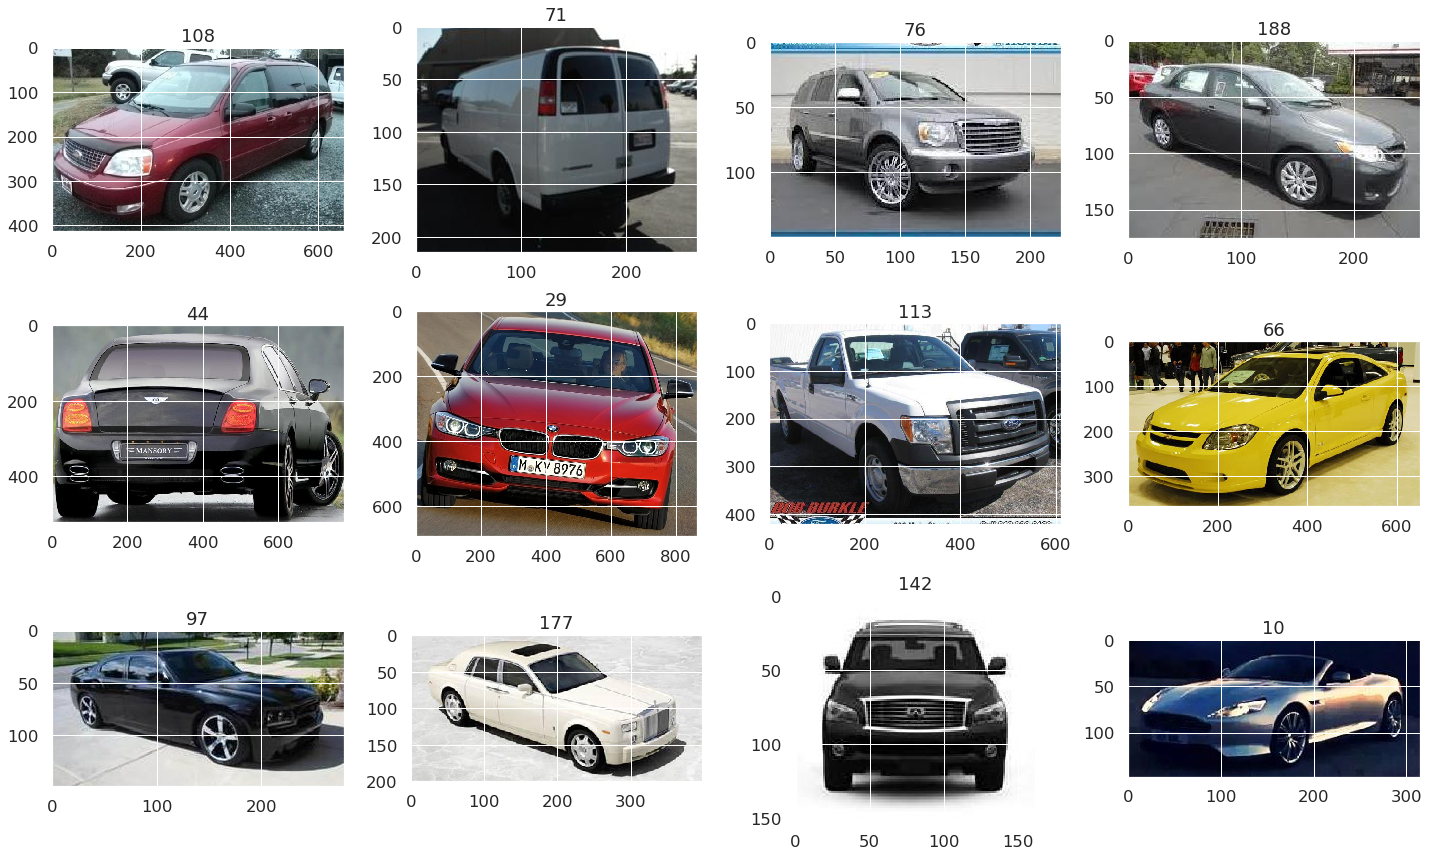

In [0]:
def display_samples(path, imgid, label, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows): 
        img = cv2.imread(os.path.join(path, f'{imgid[i]}'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i+1)
        plt.title(label[i])
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_path, train_df['img_file'], train_df['class'])

# Image generator

In [0]:
def train_datagen():
    return ImageDataGenerator(rescale=1./255,
                              rotation_range = 40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.10,
                              zoom_range=0.20,
                              fill_mode='nearest',
                              horizontal_flip=True,  # randomly flip images
                              vertical_flip=False,  # randomly flip images
                              preprocessing_function=preprocess_input
                             )

def val_datagen():
    return ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)


In [0]:
train_df['class'] = train_df['class'].astype(str)

In [0]:
classes = list(map(str, set(train_df['class'].ravel())))
class_num = len(classes)

# Modeling

 ### Custom Metric
 * 모델 성능 평가 지표인 Metric은 케라스에서 기본적으로 제공되는 옵션 말고도 사용자가 직접 구성하여 다음과 같이 추가할 수 있다.
 
 > **f1_score**
 > * F1 = 2 * (precision * recall) / (precision + recall)
 > * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
 
    def micro_f1(y_true, y_pred):
        return f1_score(y_true, y_pred, average='micro')
    
    ... 
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001),metrics=['acc', micro_f1])
                  
 이런식으로 custom metric을 사용하게되면 에러 발생.
   *TypeError: object of type 'Tensor' has no len()*
 
 scikit-learn 함수를 Keras tensor로 불러오지 못한다고 함.
 
 따라서 Keras backend를 이용해 직접 구현 필요.
 

* Reference
* https://stackoverflow.com/questions/54619732/typeerror-object-of-type-tensor-has-no-len-when-using-a-custom-metric-in-te?rq=1
* 소스 코드: http://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221226716255


In [0]:

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [0]:
def build_model():
    resnet50 = ResNet50(weights='../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False, input_shape=(SIZE,SIZE,3))
    
    model = Sequential()
    model.add(resnet50)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(class_num, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=['acc', f1score]
                 )
    
    return model

### Callback tuning

In [0]:
from datetime import datetime
from pytz import timezone, utc
KST = timezone('Asia/Seoul')

def print2(string):  
    os.system(f'echo \"{string}\"')
    print(string)

# commit시 진행상황 모니터링을 위해 추가된 클래스
class EpochLogWrite(Callback):
    def __init__(self):
        self.fold = 0
    def on_train_begin(self, logs={}):
        self.fold += 1
        print2(f'<< Fold {self.fold} >>')
    def on_epoch_begin(self, epoch, logs={}):
        tmx = utc.localize(datetime.utcnow()).astimezone(KST).time()
        print2('Epoch #{} begins at {}'.format(epoch+1, tmx))
#     def on_epoch_end(self, epoch, logs={}):
#         tmx = utc.localize(datetime.utcnow()).astimezone(KST).time()
#         print2('Epoch #{} ends at {}  acc={} val_acc={} val_f1score={}'.format(epoch+1, tmx, round(logs['acc'],4), 
#                                                                           round(logs['val_acc'],4), round(logs['val_f1score'],4) ))

In [0]:
def get_callback(model_name, patient):
    # 마지막 최고 score로부터 patience epoch만큼 score가 상승되지 않으면 training stop
    ES = EarlyStopping(
        monitor='val_f1score', 
        patience=patient, 
        mode='max', 
        verbose=1)
    # 마지막 최고 score로부터 patience epoch만큼 score가 상승되지 않으면 현재learning rate*factor값으로 learning rate업데이트
    RR = ReduceLROnPlateau(
        monitor = 'val_f1score', 
        factor = 0.65, 
        patience = patient//2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='max')
    # 최고 score를 얻은 모델 저장.
    MC = ModelCheckpoint(
        filepath=model_name, 
        monitor='val_f1score', 
        verbose=1, 
        save_best_only=True, 
        mode='max')

    return [ES, RR, MC]

# Cross validation

In [0]:
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, random_state=2019)

In [0]:
# del model
# del train_gen
# del val_gen
# K.clear_session()

In [0]:
models, hilist = [], []
toprint = EpochLogWrite()

for i, (train_idx, valied_idx) in enumerate(skf.split(train_df['img_file'], train_df['class'])):
    
    X_train = train_df.iloc[train_idx, :].reset_index()
    X_val = train_df.iloc[valied_idx, :].reset_index()
    
    train_gen = train_datagen().flow_from_dataframe(dataframe=X_train,
                                                    directory=train_path,
                                                    x_col='img_file',
                                                    y_col='class',
                                                    target_size= (SIZE,SIZE),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
    #                                                 classes = classes,
                                                    batch_size=BATCH_SIZE,
                                                    seed=2019,
                                                    shuffle=True)
    
    val_gen = val_datagen().flow_from_dataframe(dataframe=X_val,
                                                    directory=train_path,
                                                    x_col='img_file',
                                                    y_col='class',
                                                    target_size= (SIZE,SIZE),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
    #                                                 classes = classes,
                                                    batch_size=BATCH_SIZE,
                                                    seed=2019,
                                                    shuffle=True)

    model_name = './f1_resnet50_{}.h5'.format(i+1)
    models.append(model_name)
    
    model = build_model()
    
    print("\nStart")
    history = model.fit_generator(train_gen,
                                  steps_per_epoch=len(X_train)/BATCH_SIZE,
                                  epochs=30,
                                  validation_data=val_gen, 
                                  validation_steps=len(X_val)/BATCH_SIZE,
                                  shuffle=False,
                                  callbacks=get_callback(model_name, 5) + [toprint]
                                 )
    hilist.append(history)

    del model

Found 7914 validated image filenames belonging to 196 classes.
Found 2076 validated image filenames belonging to 196 classes.

Start
<< Fold 1 >>
Epoch 1/30
Epoch #1 begins at 00:54:10.116542
124/123 [==============================] - 151s 1s/step - loss: 5.3289 - acc: 0.0153 - f1score: 4.9629e-04 - val_loss: 4.6755 - val_acc: 0.0684 - val_f1score: 0.0307

Epoch 00001: val_f1score improved from -inf to 0.03067, saving model to ./f1_resnet50_1.h5
Epoch 2/30
Epoch #2 begins at 00:56:46.717410
124/123 [==============================] - 126s 1s/step - loss: 4.0410 - acc: 0.1452 - f1score: 0.0447 - val_loss: 2.7897 - val_acc: 0.3213 - val_f1score: 0.2299

Epoch 00002: val_f1score improved from 0.03067 to 0.22992, saving model to ./f1_resnet50_1.h5
Epoch 3/30
Epoch #3 begins at 00:58:53.812852
124/123 [==============================] - 131s 1s/step - loss: 2.5652 - acc: 0.3904 - f1score: 0.2540 - val_loss: 1.8030 - val_acc: 0.5645 - val_f1score: 0.4434

Epoch 00003: val_f1score improved from

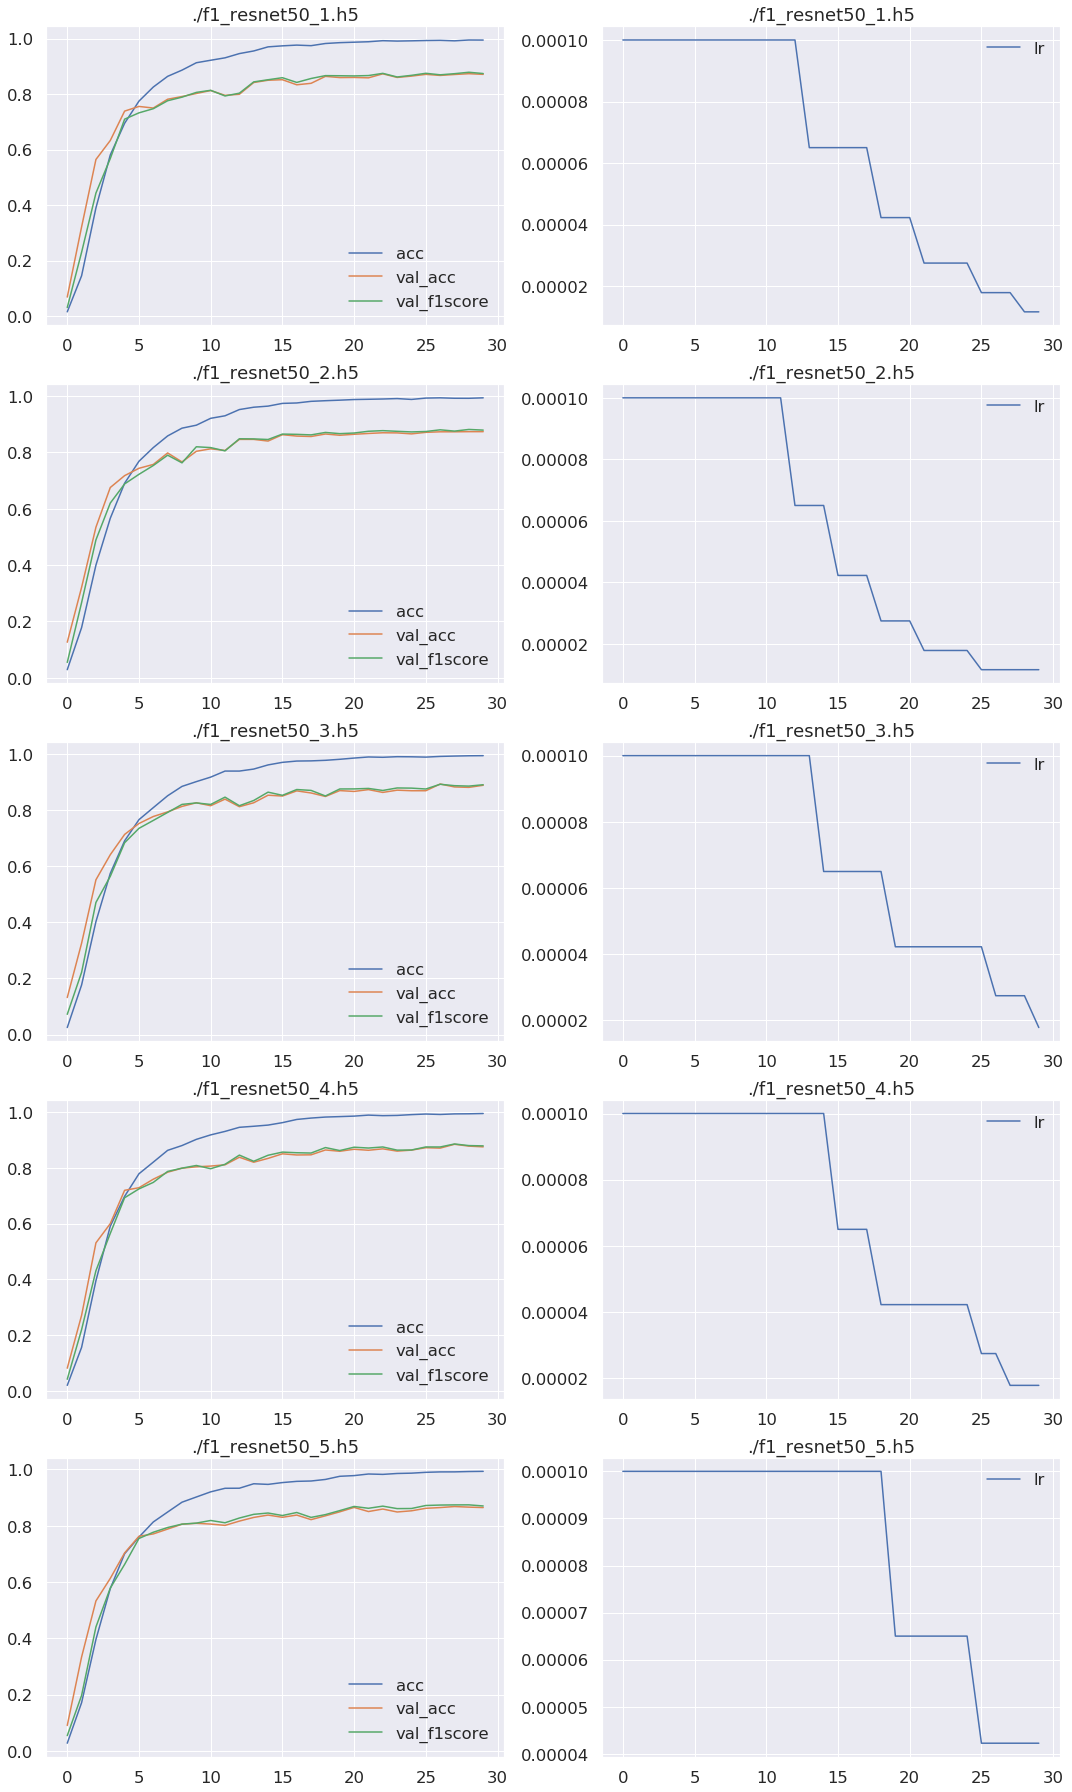

In [0]:

fig=plt.figure(figsize=(15, 25))

for i in range(5): 
    history_df = pd.DataFrame(hilist[i].history)
    fig.add_subplot(5, 2, 2*i+1)
    plt.plot(history_df[['acc', 'val_acc', 'val_f1score']]) 
    plt.title(models[i])
    plt.legend(['acc', 'val_acc', 'val_f1score'])
    
    fig.add_subplot(5, 2, 2*(i+1))
    plt.plot(history_df['lr']) 
    plt.title(models[i])
    plt.legend(['lr'])

plt.tight_layout()

# Prediction & Ensemble

In [0]:
test_gen = val_datagen().flow_from_dataframe(dataframe=test_df,
                                                directory=test_path,
                                                x_col='img_file',
                                                y_col=None,
                                                target_size= (SIZE,SIZE),
                                                color_mode='rgb',
                                                class_mode=None,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)

Found 6150 validated image filenames.


In [0]:
predictions = []

for i, name in enumerate(models):
    model = build_model()
    model.load_weights(name)
    test_gen.reset()
    y_test = model.predict_generator(generator=test_gen, steps = len(test_df)/BATCH_SIZE, verbose=1 )
    predictions.append(y_test)
    
    del model
    

97/96 [==============================] - 49s 507ms/step


In [0]:
y_pred = np.mean(predictions, axis=0)
y_pred = np.argmax(y_pred, axis=1)

# Generator class dictionary mapping
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
preds = [labels[k] for k in y_pred]

In [0]:
submit_df = pd.read_csv('../input/2019-3rd-ml-month-with-kakr/sample_submission.csv')
submit_df['class'] = preds

print(submit_df.shape)
print(submit_df.head())

(6150, 2)
         img_file class
0  test_00001.jpg   124
1  test_00002.jpg    98
2  test_00003.jpg   157
3  test_00004.jpg    94
4  test_00005.jpg    18


In [0]:
submit_df.to_csv('./submission.csv', index=False)